In [ ]:
# !pip install -r requirements.txt 

from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
from PIL import Image, ImageDraw, ImageFont
from qwen_vl_utils.vision_process import smart_resize

def get_font():
    font_path = "SimHei.ttf"
    font_size = 15
    font = ImageFont.truetype(font_path, font_size)
    return font

font = get_font()

def draw_bboxes(image_path, bbox_results):
    """
    Draw bounding boxes on the image based on grounding results.
    image_path: str, path to the image file
    bbox_results: list, list of grounding results
    """
    try:
        # Open the image
        image = Image.open(image_path)
        width, height = image.size
        resized_height, resized_width = smart_resize(height, width)
        print(f'before smart resize, width: {width}, height: {height}')
        print(f'after smart resize, width: {resized_width}, height: {resized_height}')
        scale_x = width / resized_width
        scale_y = height / resized_height
        draw = ImageDraw.Draw(image)
        
        # Draw each bounding box
        for result in bbox_results:
            bbox = result.get('bbox_2d', [])
            if len(bbox) == 4:
                # Scale bbox coordinates to original image size (before smart_resize)
                x1, y1, x2, y2 = bbox
                bbox = [x1 * scale_x, y1 * scale_y, x2 * scale_x, y2 * scale_y]
                # Draw rectangle
                draw.rectangle(bbox, outline='red', width=2)
                # Draw text
                text = result.get('text_content', '')
                if text == '':
                    text = result.get('label', '')
                draw.text((bbox[0], bbox[1] - 15), text, font=font, fill='red')
        
        return image
    except Exception as e:
        print(f"Error drawing bounding boxes: {e}")
        return None

# replace the absolute path to XiaomiMiMo/MiMo-VL-7B-RL
rl_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "XiaomiMiMo/MiMo-VL-7B-RL",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2", # enable FlashAttention for faster inference since MiMo-VL thinks
    device_map="auto",
)

sft_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "XiaomiMiMo/MiMo-VL-7B-SFT",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2", # enable FlashAttention for faster inference since MiMo-VL thinks
    device_map="auto",
)

processor = AutoProcessor.from_pretrained("XiaomiMiMo/MiMo-VL-7B-RL")

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [2]:
def inference(model, messages, max_new_tokens=16384, temperature=0.1, top_p=0.95, do_sample=True):
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)

    generated_ids = model.generate(
        **inputs, 
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_p=top_p,
        do_sample=do_sample,
        pad_token_id=processor.tokenizer.eos_token_id
    )
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text

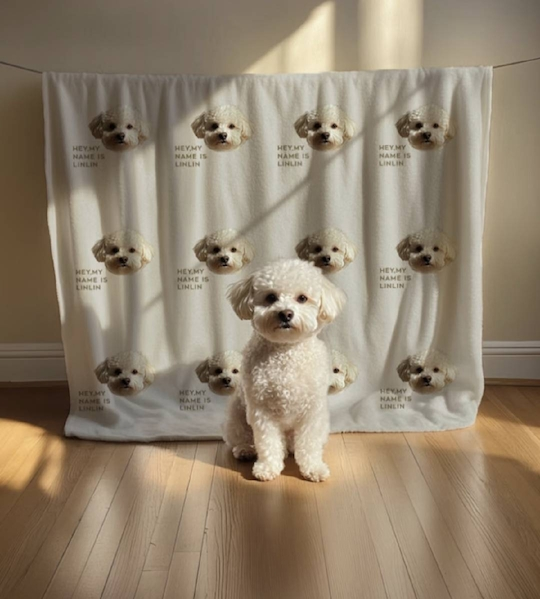

In [3]:
image_path = "example_images/dogs.jpeg"
Image.open(image_path)

In [4]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image_path,
            },
            {"type": "text", "text": "Detect all poodles from the image and output a JSON in the format [{{\"bbox_2d\": [...], \"label\": \"{{label_name}}\"}}, ...]."},
        ],
    }
]
rl_output = inference(rl_model, messages, temperature=0.2)
print(rl_output[0])

<think>
</think>

```json
[
	{"bbox_2d": [222, 253, 348, 535], "label": "Poodle"},
	{"bbox_2d": [390, 103, 440, 167], "label": "Poodle"},
	{"bbox_2d": [289, 102, 345, 164], "label": "Poodle"},
	{"bbox_2d": [187, 101, 249, 165], "label": "Poodle"},
	{"bbox_2d": [87, 103, 147, 164], "label": "Poodle"},
	{"bbox_2d": [90, 227, 149, 286], "label": "Poodle"},
	{"bbox_2d": [190, 227, 250, 288], "label": "Poodle"},
	{"bbox_2d": [291, 226, 348, 288], "label": "Poodle"},
	{"bbox_2d": [391, 226, 449, 288], "label": "Poodle"},
	{"bbox_2d": [393, 349, 449, 408], "label": "Poodle"},
	{"bbox_2d": [292, 352, 348, 409], "label": "Poodle"},
	{"bbox_2d": [192, 349, 248, 409], "label": "Poodle"},
	{"bbox_2d": [92, 349, 152, 409], "label": "Poodle"}
]
```


before smart resize, width: 540, height: 599
after smart resize, width: 532, height: 588


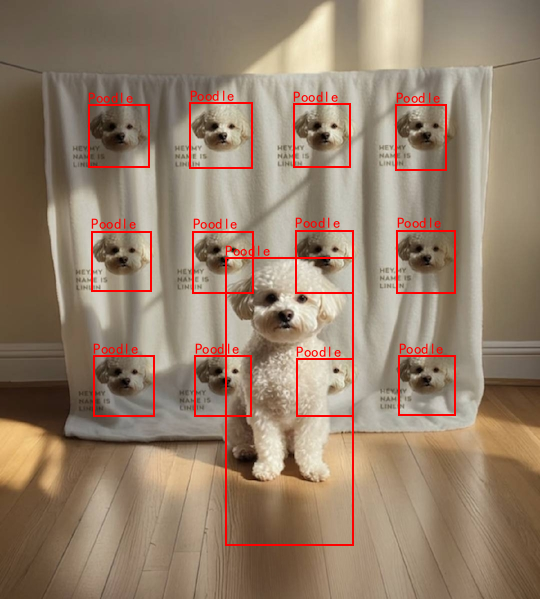

In [5]:
import json
import re

# Extract JSON content between ```json and ``` markers
json_pattern = r'```json\n(.*?)\n```'
json_match = re.search(json_pattern, rl_output[0], re.DOTALL)

if json_match:
    json_content = json_match.group(1)
    bbox_results = json.loads(json_content)
else:
    print("No JSON content found between ```json markers")
    bbox_results = []

image_with_bboxes = draw_bboxes(image_path, bbox_results)
image_with_bboxes.show()